# DreamerV2

Advanced, Model- ased RL algorithm designed for efficient learning by leveraging an internal latent-space world model. Unlike traditional RL methods, which require extensive interactions with real environment, it reduces substantially sample complexity by performing most learning within imagined trajectories.
DreamerV2 is then:
- **Sample Efficient**: Drastically reduces the required umber of interactions with the real environment.
- **High-dimensional**: Can efficiently process raw pixel observations.
- **Long-term Planning**: Performs effective long-horizon decision-making by modeling uncertainty explicitly through latent imagination.
DreamerV2 addresses Model bias and compounding predicion errors, which are errors that accumulate over time due to the model's inability to perfectly predict the environment, by using a robust latent representation and advanced recurrent architectures to stabilize long-term imagination rollouts. 

## Background

1. Latent-Space Representations:
Compresses high dimensional, redundant observations (like images) into low-dimensional embedding, capturing only essential features necessary for decision-making.

2. Recurrent State-Space Models (RSSM):
Combine deterministic and stochastic latent variables with recurrent neural networks (GRU, LSTM) to predict future states, thereby handling uncertainty and temporal dependencies effectively.

3. Imagination-based RL:
Rather than relying exclusively on real interactions, these methods generate synthetic trajectories within a learned model to efficienlty optimize the policy, drastically reducing sample complexity.

## Theory

DreamerV2 consists of several interacting NN components:
1. **Representation Model**(Encoder): Encodes observations $x_t$ into latent variables $z_t$.
2. Transition Model (RSSM): Predicts future latent states, consisting of:
    - **Deterministic hidden state**: $h_t$.
    - **Stochastic latent variable**: $z_t$.
3. **Reward Model**: Predicts immediate rewards from latent states.
4. **Policy Network (Actor)**: Optimizes actions within the latent imagination.
5. **Value Network (Critic)**: Predicts expected cumulative returns from latent states.

The main training loop includes:
1. World Model Learning: Encoding observations and learning latent dynbamics and rewards.
2. Imagination-based Planning: Generating imagined future rollouts and optimizing the policy network based
3. Real Environment Interaction: Deploying the policy to collect real observations to update the world model.

## Mathematics

- Observations: $x_t$, Actions: $a_t$, Rewards: $r_t$,
- Latent states:
    - Deterministic hidden state: $h_t$.
    - Stochastic latent state: $z_t$.
- RSSM parameters: $\theta$, Encoder parameters: $\phi$, Actor parameters: $\psi$, Critic parameters: $\xi$.
- Discount Factor: $\gamma$, Learning Rate: $\alpha$.

### RSSM Dynamics
Explicitly models uncertainty via stochastic latent variables and maintains temporal context via a recurrent hidden state:
$$h_t = f_\theta(h_{t-1}, z_{t-1}, a_{t-1})$$
Stochastic latent variables are inferred and sampled as:
- Prior $p_\theta(z_t|h_t)$
- Posterior(approx.): $q_\phi(z_t|h_t, x_t)$
Thus, the latent state at timestep t is:
$$s_t = (h_t, z_t)$$

### World Model Loss (Variational Lower Bound)

The world model is optimized by maximizing the **Evidence Lower Bound** (ELBO) of observations:
$$L_{model}(\theta, \phi) = \mathbb{E}_{q_\phi(z_{\leq T}| x_{\leq T},a_{\leq T})} [\sum_{t=1}^{T} \log p_\theta(x_t| h_t,z_t) - KL(q_\pi(z_t|h_t, x_t)||p_\theta(z_t|h_t))]$$
Where:
- $log p_\theta(x_t| h_t,z_t)$: Reconstruction likelihood encourages accurate latent representation.
- KL term: Regularizes posterior to remain close to prior, balancing representation accuracy with regularization.

### Reward Value Prediction
DreamerV2 learns separate networks for reward and value estimation:
- Reward Model: Predicts immediate rewards from latent states.
$$r_t \sim \hat{r}_t = r_\eta(h_t, z_t)$$
- Value Model(Critic): estimates expected cumulative returns:
$$V_\xi(h_t, z_t) \approx \mathbb{E}[\sum_{\tau = t}^{T} \gamma^{\tau - t} \hat{r}_\tau]$$
The critic is trained using temporal difference learning within imagined trajectories:
$$L_{value}(\xi) = \mathbb{E}_{p_\theta(z_{\leq T}| x_{\leq T},a_{\leq T})} [\sum_{t}(V_\xi(s_t) -(r_\eta(s_t,a_t) + \gamma V_\xi(s_{t+1}))^2]$$ 

## Policy Optimization in Imagination (Actor Loss)
The policy is optimized entirely via imagined rollouts. The objective is maximising the rpedicted cumulative rewards:
$$ L_{actor}(\phi) = - \mathbb{E}_{p_\theta(s_{> T}| s_t, pi_\psi)} [\sum_{t} V_\xi(s_t)]$$
the maximizes expected future returns in the imagined trajectories, leading to improved real-world policy performance.

## Implementation

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Representation Model
class Encoder(nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# RSSM Dynamics (Transition Model)
class RSSM(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.rnn = nn.GRUCell(latent_dim+action_dim, latent_dim)
        self.latent_mu = nn.Linear(latent_dim, latent_dim)
        self.latent_logvar = nn.Linear(latent_dim, latent_dim)

    def forward(self, h,z,a):
        x = torch.cat([z,a],dim=-1)
        h_next = self.rnn(x,h)
        mu, logvar = self.latent_mu(h_next), self.latent_logvar(h_next)
        z_next = mu + torch.exp(logvar * 0.5) * torch.randn_like(mu)
        return h_next, z_next, mu, logvar

In [14]:
# Actor, Critic, Reward Nets

class Actor(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim), nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
    
class Critic(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, z):
        return self.model(z)
    
class RewardModel(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, z):
        return self.model(z)

In [15]:
#DreamerV2 Agent

class DreamerAgent:
    def __init__(self, obs_dim, action_dim, latent_dim = 32):
        self.encoder = Encoder(obs_dim, latent_dim).to(device)
        self.rssm = RSSM(latent_dim, action_dim).to(device)
        self.actor = Actor(latent_dim, action_dim).to(device)
        self.critic = Critic(latent_dim).to(device)
        self.reward_model = RewardModel(latent_dim).to(device)
        
        self.optim_model = optim.Adam(list(self.encoder.parameters()) + list(self.rssm.parameters()) + list(self.reward_model.parameters()), lr=3e-4)
        self.optim_actor = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.optim_critic = optim.Adam(self.critic.parameters(), lr=3e-4)

    def imagine(self, z,h, horizon=15):
        zs, hs, rewards = [], [], []
        for _ in range(horizon):
            a = self.actor(z)
            h,z, _,_ = self.rssm(h,z,a)
            r = self.reward_model(z)
            zs.append(z), hs.append(h), rewards.append(r)
        return zs, hs, rewards
    
    def train(self, real_obs, real_actions, real_rewards):
        z = self.encoder(real_obs[0])
        h = torch.zeros_like(z)

        # World Model Learning
        recon_loss = 0
        for t in range(len(real_actions)):
            h, z, mu, logvar = self.rssm(h, z, real_actions[t])
            reward_pred = self.reward_model(z)
            recon_loss += (reward_pred - real_rewards[t]).pow(2).mean() + -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

        self.optim_model.zero_grad()
        recon_loss.backward()
        self.optim_model.step()

        # Imagined Trajectories for policy and value
        with torch.no_grad():
            zs, hs, rewards = self.imagine(z.detach(), h.detach())
        
        values = [self.critic(z.detach()) for z in zs]

        targets = []
        for i in range(len(rewards)):
            reward = rewards[i].detach()
            if i+1 < len(values):
                target = reward + 0.99 * values[i+1].detach()
            else:
                target = reward
            targets.append(target)

        #Critic Update
        value_loss = sum((values[i] - targets[i]).pow(2).mean() for i in range(len(values)))
        self.optim_critic.zero_grad()
        value_loss.backward()
        self.optim_critic.step()

        #Actor Update
        zs_actor, _, _ = self.imagine(z.detach(), h.detach())
        actor_loss = -sum(self.critic(z).mean() for z in zs_actor)
        self.optim_actor.zero_grad()
        actor_loss.backward()
        self.optim_actor.step()

Episode: 0, Reward: -2.0546528784648523
Episode: 1, Reward: -3.7437222324707076
Episode: 2, Reward: -1.1145175284066375
Episode: 3, Reward: -2.5700051245964874
Episode: 4, Reward: -3.649885728377622
Episode: 5, Reward: -2.655493199143356
Episode: 6, Reward: -2.174071936989553
Episode: 7, Reward: -1.7237313311098417
Episode: 8, Reward: -4.548262665787252
Episode: 9, Reward: -3.2693187720011814
Episode: 10, Reward: -3.641746772295978
Episode: 11, Reward: -2.614426024539506
Episode: 12, Reward: -2.885255983690158
Episode: 13, Reward: -4.007152626706676
Episode: 14, Reward: -4.578455800204929
Episode: 15, Reward: -4.039986062940572
Episode: 16, Reward: -4.548049311238123
Episode: 17, Reward: -4.616050120208955
Episode: 18, Reward: -5.253468909287032
Episode: 19, Reward: -6.533259316608662
Episode: 20, Reward: -5.333492748171143
Episode: 21, Reward: -5.516887088015152
Episode: 22, Reward: -5.79349307084449
Episode: 23, Reward: -5.799521595055809
Episode: 24, Reward: -5.621189570891531
Episo

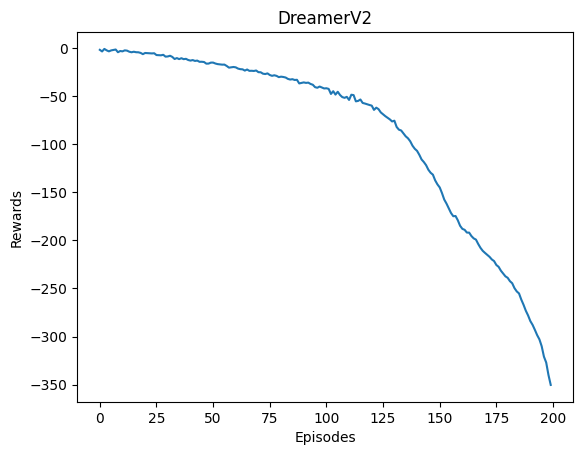

In [16]:
env = gym.make('HalfCheetah-v5')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = DreamerAgent(obs_dim, action_dim)
episodes = 200
rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0
    real_obs, real_actions, real_rewards = [], [], []

    for step in range(1000):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        z = agent.encoder(obs_tensor)
        action = agent.actor(z).detach().cpu().numpy().squeeze(0)
        next_obs, reward, truncated, terminated,_ = env.step(action)
        done = truncated or terminated

        real_obs.append(obs_tensor.squeeze(0))
        real_actions.append(torch.tensor(action, dtype=torch.float32).to(device))
        real_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))

        obs = next_obs
        ep_reward += reward

        if done:break
    agent.train(real_obs, real_actions, real_rewards)
    rewards.append(ep_reward)
    print(f"Episode: {ep}, Reward: {ep_reward}")

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DreamerV2')
plt.show()

## Extensions

## Intrinsic Motivation For Enhanced Exploration
Traditional RL relies primarily on extrinsic rewards, but many environments provide sparse or delayed rewards, Instrinsic motivation adds internal rewards based on the novelty or uncertainty of observatons or latent states, encouraging the agent to explore new regions in the state space proactively.
DreamerV2 naturally integrates intrinsic motivation by using model uncertainty (from RSSM) to compute intrinsic rewards.
This improves performance in environments with sparse external rewards, accellerates learning by encouraging exploration of uncertain states and enhances robustness against suboptimal local solutions.

In [17]:
class RewardModelWithIntrinsic(nn.Module):
    def __init__(self, latent_dim, intrinsic_scale=0.1):
        super().__init__()
        self.extrinsic = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.intrinsic = intrinsic_scale

    def forward(self, z, predition_error):
        extrinsic_reward = self.extrinsic(z)
        intrinsic_reward = predition_error.unsqueeze(-1) * self.intrinsic
        total_reward = extrinsic_reward + intrinsic_reward
        return total_reward, extrinsic_reward, intrinsic_reward

In [18]:
class RSSMWithIntrinsic(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.rnn = nn.GRUCell(latent_dim+action_dim, latent_dim)
        self.latent_mu = nn.Linear(latent_dim, latent_dim)
        self.latent_logvar = nn.Linear(latent_dim, latent_dim)

    def forward(self, h,z,a):
        x = torch.cat([z,a],dim=-1)
        h_next = self.rnn(x,h)
        mu, logvar = self.latent_mu(h_next), self.latent_logvar(h_next)
        z_next = mu + torch.exp(logvar * 0.5) * torch.randn_like(mu)
        prediction_error = torch.mean((z_next - mu).pow(2), dim=-1)
        return h_next, z_next, mu, logvar, prediction_error

In [ ]:
def DreamerV2IntrinsicRew( DreamerAgent):
    def __init__(self, obs_dim, action_dim, latent_dim = 32):
        super(DreamerV2IntrinsicRew, self).__init__(obs_dim, action_dim, latent_dim)
        self.reward_model = RewardModelWithIntrinsic(latent_dim).to(device)
        self.rssm = RSSMWithIntrinsic(latent_dim, action_dim).to(device)

    def train(self, real_obs, real_actions, real_rewards):
        z = self.encoder(real_obs[0])
        h = torch.zeros_like(z)

        # World Model Learning, with simple intrinsic reward based on prediction uncertainty in RSSM
        recon_loss = 0
        intrinsic_rewards = []
        for t in range(len(real_actions)):
            h, z, mu, logvar, prediction_error = self.rssm(h, z, real_actions[t])
            reward_pred, _, intrinsic_reward = self.reward_model(z, prediction_error)
            intrinsic_rewards.append(intrinsic_reward.detach())

            recon_loss += (reward_pred - real_rewards[t]).pow(2)
            kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

            recon_loss += recon_loss.mean() + kl_loss

        self.optim_model.zero_grad()
        recon_loss.backward()
        self.optim_model.step()

        # Imagined Trajectories for policy and value
        zs, hs, imagined_rewards = [], [], []
        z_imagine, h_imagine = z.detach(), h.detach()
        
        #Horizon range
        for _ in range(15):
            a = self.actor(z_imagine)
            h_imagine, z_imagine, _, _, prediction_error = self.rssm(h_imagine, z_imagine, a)
            r_total, _,_ = self.reward_model(z_imagine, prediction_error)
            imagined_rewards.append(r_total)
            zs.append(z_imagine)

        
        values = [self.critic(z) for z in zs]

        targets = []
        for i in range(len(imagined_rewards)):
            reward = imagined_rewards[i]
            if i+1 < len(values):
                target = reward + 0.99 * values[i+1].detach()
            else:
                target = reward
            targets.append(target)

        #Critic Update
        value_loss = sum((values[i] - targets[i]).pow(2).mean() for i in range(len(values)))
        self.optim_critic.zero_grad()
        value_loss.backward()
        self.optim_critic.step()

        #Actor Update
        actor_loss = -sum(self.critic(z).mean() for z in zs)
        self.optim_actor.zero_grad()
        actor_loss.backward()
        self.optim_actor.step()


In [20]:
agent = DreamerV2IntrinsicRew(obs_dim, action_dim)
episodes = 200
rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0
    real_obs, real_actions, real_rewards = [], [], []

    for step in range(1000):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        z = agent.encoder(obs_tensor)
        action = agent.actor(z).detach().cpu().numpy().squeeze(0)
        next_obs, reward, truncated, terminated,_ = env.step(action)
        done = truncated or terminated

        real_obs.append(obs_tensor.squeeze(0))
        real_actions.append(torch.tensor(action, dtype=torch.float32).to(device))
        real_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))

        obs = next_obs
        ep_reward += reward

        if done:break
    agent.train(real_obs, real_actions, real_rewards)
    rewards.append(ep_reward)
    print(f"Episode: {ep}, Reward: {ep_reward}")

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DreamerV2')
plt.show()

TypeError: DreamerV2IntrinsicRew() takes 1 positional argument but 2 were given

## Attention-Based Recurrent State-Space Models
Standard RSSM use RNN(GRU, LSTM) limiting the ability to acpture long-range dependencies efficiently, attention mechanisms allow latent state represetnations to attend selectively to past states, improving modeling of complex temporal relationships.
This improves handling of environments with long-horizon dependencies, Enhances modeling accuracy and robustness, Potentially improves long-term planning and decision-making.

In [ ]:
class AttentionRSSM(nn.Module):
    def __init__(self, latent_dim, action_dim, attention_heads=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.action_dim = action_dim

        self.attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=attention_heads)

        self.gru_cell = nn.GRUCell(latent_dim+action_dim, latent_dim)

        self.mu_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)

    def forward(self, past_latents, h, z, a):
        query = (z+h).unsqueeze(0)
        att_output, _ = self.attention(query, past_latents, past_latents)
        att_output = att_output.squeeze(0)

        gru_input = torch.cat([att_output, a], dim=-1)
        h_next = self.gru_cell(gru_input, h)

        mu = self.mu_layer(h_next)
        logvar = self.logvar_layer(h_next)
        z_next = mu + torch.exp(logvar * 0.5) * torch.randn_like(mu)

        return h_next, z_next, mu, logvar

In [ ]:
class DreamerV2AttentionAgent(DreamerAgent):
    def __init__(self, obs_dim, action_dim, latent_dim=32):
        super(DreamerV2AttentionAgent, self).__init__(obs_dim, action_dim, latent_dim)
        self.rssm = AttentionRSSM(latent_dim, action_dim).to(device)

        params = list(self.encoder.parameters()) + list(self.rssm.parameters()) + list(self.reward_model.parameters())
        self.optim_model = optim.Adam(params, lr=3e-4)

    def train(self, real_obs, real_actions, real_rewards):
        z = self.encoder(real_obs[0])
        h = torch.zeros_like(z)

        # World Model Learning
        recon_loss = 0
        for t in range(len(real_actions)):
            past_latents = torch.stack(real_obs[:t+1])
            h, z, mu, logvar = self.rssm(h, z, real_actions[t], past_latents)
            reward_pred = self.reward_model(z)
            recon_loss += (reward_pred - real_rewards[t]).pow(2).mean() + -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

        self.optim_model.zero_grad()
        recon_loss.backward()
        self.optim_model.step()

        # Imagined Trajectories for policy and value
        with torch.no_grad():
            zs, hs, rewards = self.imagine(z.detach(), h.detach())
        
        values = [self.critic(z.detach()) for z in zs]

        targets = []
        for i in range(len(rewards)):
            reward = rewards[i].detach()
            if i+1 < len(values):
                target = reward + 0.99 * values[i+1].detach()
            else:
                target = reward
            targets.append(target)

        #Critic Update
        value_loss = sum((values[i] - targets[i]).pow(2).mean() for i in range(len(values)))
        self.optim_critic.zero_grad()
        value_loss.backward()
        self.optim_critic.step()

        #Actor Update
        zs_actor, _, _ = self.imagine(z.detach(), h.detach())
        actor_loss = -sum(self.critic(z).mean() for z in zs_actor)
        self.optim_actor.zero_grad()
        actor_loss.backward()
        self.optim_actor.step()

### Pixel Based DreamerV2 (Vison-Based RL)
DreamerV2 can compress visual observations into a low-dimensional latent representation enabling effective policy optimization directly from pixels, a convolutional encoder maps images to latent states, enabling end-to-end learning from visual inputs.
This allows DreamerV2 to handle high-dimensional observations, such as images, effectively, and improves performance in environments with complex visual features.

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, latent_dim)
        )
    def forward(self, x):
        return self.conv_net(x)